In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/lyrics_data_v2.csv')
df = df.drop(['Unnamed: 0'], axis=1)

### Exploration

In [3]:
#Gathering all words into a single list
tokens = []
for i in range(len(df)):
    temp = [t for t in df['Song Lyrics'][i].split()]
#     print(temp)
    tokens = tokens + temp

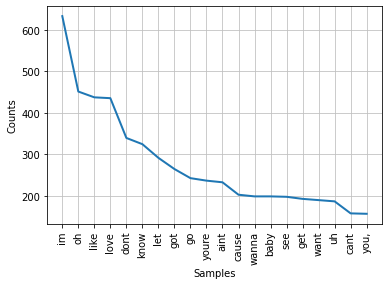

In [4]:
import nltk
from nltk.corpus import stopwords

sr= stopwords.words('english')
clean_tokens = tokens[:]
for token in tokens:
    if token in stopwords.words('english'):
        clean_tokens.remove(token)
        
freq = nltk.FreqDist(clean_tokens)
# for key,val in freq.items():
#     print(str(key) + ':' + str(val))
freq.plot(20, cumulative=False)

In [5]:
def multi_color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = clean_tokens
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    color_func=multi_color_func,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

fig

ModuleNotFoundError: No module named 'wordcloud'

### TF-IDF

In [334]:
speech = df['Song Lyrics']
speech = speech.str.replace('[^a-zA-Z]', ' ').str.lower()
words = pd.Series(speech.str.split().sum()).value_counts()

In [343]:
tfidf = pd.DataFrame([], index=speech.index)  # dataframe of documents
tf_denom = (df['Song Lyrics'].str.count(' ') + 1)
for w in words.iloc[0:500].index:
    # imperfect pattern match for speed
    re_pat = '%s' % w
    tf = df['Song Lyrics'].str.count(re_pat) / tf_denom
    idf = np.log(len(df) / df['Song Lyrics'].str.count(re_pat).sum())
    tfidf[w] =  tf * idf
tfidf.head()

,you,i,the,me,to,a,my,and,it,oh,...,liquor,saw,sit,ready,temptation,any,miss,closer,wake,kitty
0,-0.226410,-1.349665,-0.051215,-0.039077,-0.162964,-1.417954,-0.082382,-0.128538,-0.024215,-0.113221,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,-0.099229,-0.942526,-0.025899,-0.243718,-0.117729,-1.412375,-0.087949,-0.083573,-0.073473,-0.211403,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,-0.395772,-0.936213,-0.022381,-0.273230,-0.071217,-0.901320,-0.048002,-0.032098,-0.042329,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,-0.000000,-1.446605,-0.000000,-0.072292,-0.032302,-1.430845,-0.000000,-0.000000,-0.011200,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,-0.242232,-1.375218,-0.154108,-0.052259,-0.015567,-1.580250,-0.097931,-0.085950,-0.048577,-0.011647,...,0.0,0.0,0.0,0.0,0.0,0.002635,0.0,0.0,0.0,0.0


In [349]:
list(tfidf.idxmax(axis=1)[:20])

['run',
 'shoot',
 'youve',
 'soy',
 'inside',
 'halo',
 'sweet',
 'www',
 'freedom',
 'home',
 'upgrade',
 'myself',
 'flawless',
 'shakira',
 'either',
 'wanted',
 'find',
 'hurts',
 'temptation',
 'looking']

# Model Creation

In [187]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten

### Probability

In [319]:
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

# Create a placeholder for model
model = defaultdict(lambda: defaultdict(lambda: 0))

for sentence in df['Song Lyrics']:
#     print(sentence + '\n')
    sentence = sentence.split()
    for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
#         print(w1,w2,w3)
        model[(w1, w2)][w3] += 1

for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count
        

### N-Gram Calculator

In [194]:
trigrams = ngrams(tokens,3)
tricount = Counter(trigrams)

trivals = tricount.values()
denom = sum(vals)
trivals = [x for x in trivals]
phrase = [x for x in tricount.keys()]
tridf = pd.DataFrame({'Phrase': phrase, 'Freq': trivals})

In [195]:
quadgrams = ngrams(tokens,4)
quadcount = Counter(quadgrams)

quadvals = quadcount.values()
denom = sum(vals)
quadvals = [x for x in quadvals]
phrase = [x for x in quadcount.keys()]
quaddf = pd.DataFrame({'Phrase': phrase, 'Freq': quadvals})

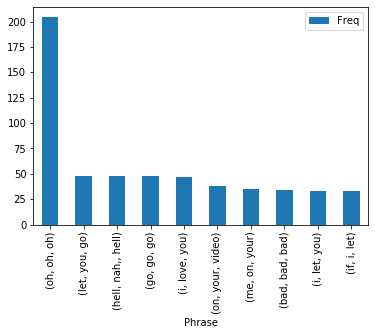

In [196]:
tridf.sort_values(by='Freq', ascending=False)[:10].plot.bar(x = 'Phrase', y = 'Freq')

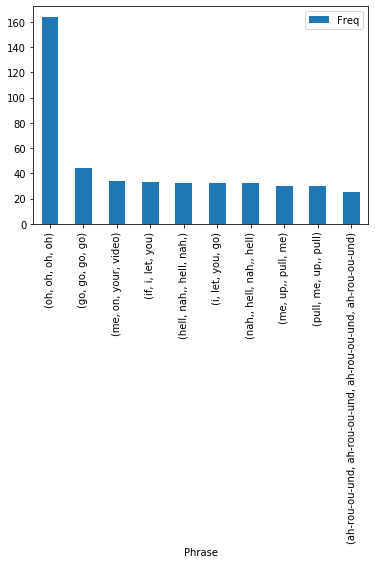

In [197]:
quaddf.sort_values(by='Freq', ascending=False)[:10].plot.bar(x = 'Phrase', y = 'Freq')

In [204]:
def ngrams_calc(lst, n):
#     lst = lst.split(' ')
    output = []
    for i in range(len(lst)-n+1):
        output.append(lst[i:i+n])
    return output